In [1]:
import json
import torch
import numpy as np
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import InterpolationMode


import sys
from pathlib import Path

notebook_path = Path().resolve()
project_root = notebook_path.parent
sys.path.append(str(project_root))

from utils import DiffusionModelPipeline, ImagePromptDataset

ModuleNotFoundError: No module named 'torch'

## Initialize Model

Observations
- inC - needs to be .vae.config.latent_channels


In [ ]:
dit_params = {
    'channels': 384,
    'nBlocks': 8,
    'nHeads': 16,
    'conditionC': 384,
    'patchSize': 1,
    'text_embed_dim': 256,
}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiffusionModelPipeline(dit_params = dit_params,
                       emaStrength= 0.999,
                       device=device)

c:\Users\wolfg\OneDrive\Documents\Projects\OMI\my-omi-code\omi_training_code\.venv\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
##Hacky work around - will fix later
model.tokenizer.name_or_path = 't5-base'
model.text_encoder.config.name_or_path = 't5-base'
model.vae.config._name_or_path = 'flux_schnell_vae'

In [ ]:
print(f"total trainable parameters: {model.total_parameters}, in mil {model.total_parameters/1e6} in bil {model.total_parameters/1e9}") 

total trainable parameters: 52366400, in mil 52.3664 in bil 0.0523664


## Test Gen

In [6]:
image = model(['a beautiful sunset over the ocean', 'some other noise'], num_inference_steps=50)

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\wolfg\OneDrive\Documents\Projects\OMI\my-omi-code\omi_training_code\utils\dit.py:105: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attnOutput = torch.nn.functional.scaled_dot_product_attention(q, k, v)
100%|██████████| 50/50 [00:00<00:00, 54.29it/s]


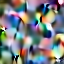

In [7]:
image[0]

In [8]:
np_img = np.array(image[0])
print(np_img.shape)
#image shape should be what we expect to output

(64, 64, 3)


## Test Training

In [9]:
# dataset = load_dataset("openmodelinitiative/initial-test-dataset")
# dataset = load_dataset("laion/laion2B-en")
# data_id = "idning/ffhq64-caption"
# data_id = "idning/ffhq128-caption"
data_id= "pcuenq/lsun-bedrooms"

ds = load_dataset(data_id)

#to run on runpod I had to comment out lines 188/189 in usr/lib/local/pyhton/datasets/features/Image.py 

# ds = load_dataset("pcuenq/lsun-bedrooms")
split_ds = ds['train'].train_test_split(test_size=0.1, seed=42)


In [10]:
transform = transforms.Compose([
    transforms.Resize((np_img.shape[0], np_img.shape[1]), interpolation=InterpolationMode.LANCZOS),
    transforms.ToTensor(),  # Converts to tensor and scales pixel values to [0, 1]
])

In [11]:
# Create the custom dataset
train_dataset = ImagePromptDataset(split_ds["train"], transform=transform, device = torch.device('cuda'), maps = ['depth','edge'])
val_dataset = ImagePromptDataset(split_ds["test"], transform=transform , device = torch.device('cuda'), maps = ['depth', 'edge'])   


In [12]:
sample = train_dataset[0]

Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\wolfg\OneDrive\Documents\Projects\OMI\my-omi-code\omi_training_code\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master


In [13]:
sample[-1].shape

torch.Size([2, 64, 64])

In [14]:
sample[0].shape

torch.Size([3, 64, 64])

In [15]:
sample[0]

tensor([[[0.6510, 0.7255, 0.8039,  ..., 0.3569, 0.3412, 0.3333],
         [0.3843, 0.4824, 0.5804,  ..., 0.3647, 0.3490, 0.3373],
         [0.1961, 0.2353, 0.2980,  ..., 0.3686, 0.3569, 0.3451],
         ...,
         [0.6549, 0.6627, 0.6667,  ..., 0.5216, 0.5176, 0.5059],
         [0.6627, 0.6588, 0.6588,  ..., 0.5176, 0.5020, 0.4824],
         [0.6353, 0.6431, 0.6431,  ..., 0.5137, 0.4980, 0.4902]],

        [[0.6471, 0.7412, 0.8275,  ..., 0.4784, 0.4627, 0.4549],
         [0.4353, 0.5137, 0.6000,  ..., 0.4863, 0.4706, 0.4588],
         [0.2941, 0.3176, 0.3686,  ..., 0.4902, 0.4784, 0.4667],
         ...,
         [0.7176, 0.7255, 0.7294,  ..., 0.4784, 0.4784, 0.4667],
         [0.7255, 0.7216, 0.7216,  ..., 0.4902, 0.4745, 0.4549],
         [0.6980, 0.7059, 0.7059,  ..., 0.4902, 0.4745, 0.4667]],

        [[0.6392, 0.7294, 0.8078,  ..., 0.3490, 0.3373, 0.3294],
         [0.4039, 0.4902, 0.5804,  ..., 0.3569, 0.3451, 0.3333],
         [0.2392, 0.2667, 0.3216,  ..., 0.3608, 0.3529, 0.

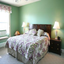

In [16]:
transforms.ToPILImage()(sample[0])

In [22]:
# Training DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=0  # Set to 0 if you encounter issues on Windows
)

# Validation DataLoader
val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

In [23]:
next(iter(train_dataloader))

Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache 

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>

In [19]:
history = model.train(train_dataloader,
            val_dataloader,
            epochs = 10000,
            log_interval= 100,
            save_interval= 1000,
            output_dir= '../results/ffhq64_caption',
            patience= 1000,
            visualize=True,
            visualize_interval= 100,
            visualize_prompt= ['A photography of a man in a suit',
                               'a photography of a woman with a tooth brush',
                               'a photography of a man with red hair',
                               'a photography of a woman with blond hair',],
            num_inference_steps= 10)

changing optimizer to AdamW and added rectified flow 


Epoch 1:   0%|          | 0/8100 [00:00<?, ?it/s]Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.ca

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>

In [ ]:
# Save history 
with open('../results/ffhq64_caption/history.json', 'w') as f:
    json.dump(history, f)
